In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trial-and-error/valid.csv
/kaggle/input/trial-and-error/train.csv
/kaggle/input/trial-and-error/test.csv
/kaggle/input/intent-definition/Definition_Intent_validation.csv
/kaggle/input/intent-definition/Definition_Intent_train.csv
/kaggle/input/intent-definition/Definition_Intent.csv
/kaggle/input/tp1234/trial_definition_large.csv
/kaggle/input/tp1234/trial_definition.csv


In [2]:
!pip install transformers
from transformers import BertTokenizer
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer
from tqdm import tqdm
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.labels = [labels[label] for label in df['Intent']]
        self.text = [tokenizer(text, padding='max_length',max_length=512, truncation=True, return_tensors='pt') for text in df['Text']]
    def classes(self):
        return self.labels
    def __len__(self):
        return len(self.labels)
    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])
    def get_batch_texts(self,idx):
        return self.text[idx]
    def __getitem__(self,idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        
        return batch_texts, batch_y

In [4]:
train_data = pd.read_csv('../input/tp1234/trial_definition_large.csv')

In [5]:
max([len(rows['Text']) for idx, rows in train_data.iterrows()])

136

In [6]:
k = 0
labels = {}
for i in train_data['Intent'].unique():
    labels[i]=k
    k+=1

In [7]:
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.drop = nn.Dropout(dropout)
        self.dense1 = nn.Linear(768,384)
        self.dense2 = nn.Linear(384,128)
        self.dense3 = nn.Linear(128,16)
        self.out = nn.Linear(16,3)
    def forward(self, inp, msk):
        _,bert_out = self.bert(input_ids = inp, attention_mask = msk, return_dict = False)
        dropped_bert_out = self.drop(bert_out)
        activated_output = F.tanh(self.dense1(dropped_bert_out))
        activated_output1 = self.dense2(activated_output)
        activated_output2 = self.dense3(activated_output1)
        fin_output = self.out(activated_output2)
        return fin_output

In [8]:
def train(model,train, val, learning_rate, epochs,batch_size):
    train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size, shuffle=True)
#     val_loader = torch.utils.data.DataLoader(val,batch_size=batch_size, shuffle=True)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    train_loss_lst = []
    val_loss_lst = []
    train_acc_lst = []
    val_acc_lst = []
    for i in range(epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for train_input,train_label in tqdm(train_loader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            train_id = train_input['input_ids'].squeeze(1).to(device)
            
            output = model(train_id,mask)
            loss = criterion(output,train_label)
            train_loss+=loss.item()
            train_acc += ((output.argmax(dim=1) == train_label).sum().item())
            
            model.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss_lst.append(train_loss/len(train))
        train_acc_lst.append(train_acc/len(train))
        torch.save(model.state_dict(), os.path.join('./', f"Bert+drop+tanh+relu-{i}.pth"),)
#         with torch.no_grad():
            
#             for val_input, val_label in val_loader:
#                 val_label = val_label.to(device)
#                 mask = val_input['attention_mask'].to(device)
#                 val_id = val_input['input_ids'].squeeze(1).to(device)
                
#                 output = model(val_id,mask)
#                 loss = criterion(output,val_label)
#                 val_loss+=loss.item()
#                 val_acc += ((output.argmax(dim=1) == val_label).sum().item())
#             val_loss_lst.append(val_loss/len(val))
#             val_acc_lst.append(val_acc/len(val))
    plt.plot(train_loss_lst,label='Loss of train data')
    plt.plot(val_loss_lst,label='Loss of validation data')
    plt.legend()
    plt.show()
    plt.plot(train_acc_lst,label='Acc of train data')
    plt.plot(val_acc_lst,label='Acc of validation data')
    plt.legend()
    plt.show()

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/8380 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Us

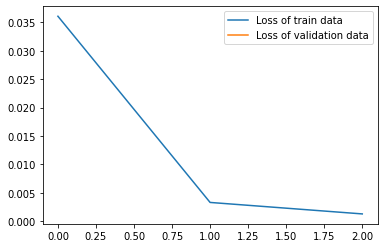

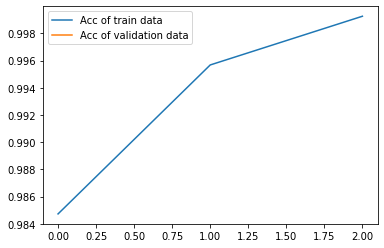

In [9]:
EPOCHS = 3
model = BertClassifier()
Learning_Rate = 1e-6

train(model,Dataset(train_data),None, Learning_Rate, EPOCHS,4)

In [10]:
def predict_intent(sentence,model):
    with torch.no_grad():
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        t = tokenizer(sentence,padding='max_length',max_length=512, truncation=True, return_tensors='pt')
        mask = t['attention_mask'].to(device)
        train_id = t['input_ids'].squeeze(1).to(device)
        outputs = model(train_id,mask)
        print(outputs.argmax(dim=1).item())

In [11]:
labels

{'oos': 0, 'definition': 1, 'greeting': 2}

In [12]:
# intent_classify = BertClassifier()
# intent_classify.load_state_dict(torch.load("./Bert+drop+tanh+relu-1.pth"))
# intent_classify.to('cuda')